# PUBG绝地求生聚类分析[双排]

<p>运用到的方法：Kmeans, AGG, DBSCAN

## 1、全特征聚类

In [1]:
import pandas as pd
import numpy as np
#读取数据集sampleSquad.csv
data = pd.read_csv('sampleDuo_V2.csv')
data.shape

(50000, 32)

In [2]:
# 挑选出用于聚类的特征
data_cluster = data.drop(columns=['winPlacePerc','matchDuration'])
column = data_cluster.columns
data_cluster.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,kill_rate,playersInGroup,weaponsPerDistance,healsPerDistance,killsPerDistance,distance_over_weapons,distance_over_heals,distance_over_kills,healthitems,skill
0,0.00,0,57.6828,0.00,0.00,0,91.56,0.00,0.00,0.00,...,0.0,2,0.008084,0.000000,0.000000,123.700000,0.0,0.000000,0,0.00
1,0.00,0,143.6240,1.04,0.00,0,32.24,1.04,1.04,67.56,...,0.5,2,0.012780,0.000000,0.006645,78.250000,0.0,150.480769,0,1.04
2,1.02,1,186.1500,1.02,0.00,2,39.78,0.00,0.00,0.00,...,0.0,2,0.000863,0.000637,0.000000,1158.750000,2317.5,0.000000,3,0.00
3,2.06,3,293.2410,1.03,1.03,1,18.54,2.06,2.06,57.12,...,0.4,2,0.001181,0.000525,0.001081,846.766667,2540.3,1233.155340,4,3.09
4,0.00,0,19.1152,0.00,0.00,0,75.92,0.00,0.00,0.00,...,0.0,2,0.008536,0.000000,0.000000,117.150000,0.0,0.000000,0,0.00


In [3]:
# Z-score标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_input = ss.fit_transform(data_cluster)
data_input

array([[-0.41644868, -0.6804515 , -0.49830031, ..., -0.48466475,
        -0.67495354, -0.71670715],
       [-0.41644868, -0.6804515 , -0.02696139, ..., -0.36436361,
        -0.67495354,  0.11961629],
       [ 1.30989958, -0.11823428,  0.2062697 , ..., -0.48466475,
         0.08160774, -0.71670715],
       ...,
       [ 4.86414599, -0.6804515 ,  1.38245066, ...,  0.22453544,
        -0.67495354,  0.11961629],
       [-0.41644868, -0.6804515 , -0.38527269, ...,  0.70092766,
         2.3512916 ,  0.13569943],
       [-0.41644868, -0.6804515 , -0.81465788, ..., -0.48466475,
        -0.67495354, -0.71670715]])

### Kmeans聚类

In [4]:
# k-means聚类
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#####这里k-means的聚类数需要看上面画出的图自行判断
kmeans = KMeans(n_clusters=6)#n_clusters即为K值
data_cluster['kmeans'] = kmeans.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['kmeans']))
print(len(np.unique(data_cluster['kmeans'])))

0.2638441272653186
6


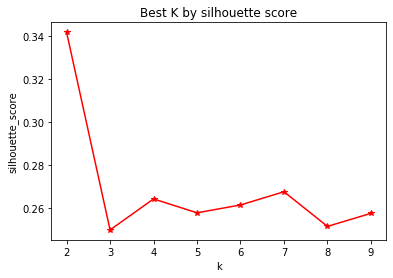

In [5]:
# K-means调参
import matplotlib.pyplot as plt
K=range(2,10)
score=[]
for k in K:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(data_input)
    score.append(silhouette_score(data_input,kmeans.labels_,metric='euclidean'))
    
plt.plot(K,score,'r*-')
plt.xlabel('k')
plt.ylabel(u'silhouette_score')
plt.title(u'Best K by silhouette score')
plt.show()

### AGG层次聚类

In [6]:
# 层次聚类
from sklearn.cluster import AgglomerativeClustering
#####这里的distance_threshold需要自己试，试了10、100、500、300
AGG = AgglomerativeClustering(distance_threshold=300,n_clusters=None,linkage = 'ward')#distance_threshold为停止合并簇类的距离
data_cluster['agg'] = AGG.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['agg']))
print(len(np.unique(data_cluster['agg'])))

0.26642227601527624
7


In [7]:
# 采用层次聚类法得到的聚类中心，作为k-means算法的初始点
center_point = data_cluster.groupby('agg').mean()[column]# 计算聚类中心点
print(center_point)
#####这里k-means的聚类数需要看上面画出的图自行判断
kmeans = KMeans(n_clusters=7,init=center_point,n_init=1)#自定义k-means初始聚类中心
data_cluster['kmeans_init_by_agg'] = kmeans.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['kmeans_init_by_agg']))
print(len(np.unique(data_cluster['kmeans_init_by_agg'])))

      assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
agg                                                                       
0    0.154146  1.234231   167.959990  0.889594       0.295906  1.535155   
1    0.113672  0.476248    44.499536  0.140766       0.000000  0.639177   
2    0.268919  1.291775   206.989351  1.069811       0.408851  1.554479   
3    0.617023  2.851175   303.919008  1.305379       0.535953  2.869452   
4    0.296189  1.967202   128.995531  0.537019       0.140735  1.698590   
5    0.919031  4.458996   513.763733  2.501302       1.202584  5.605119   
6    0.389340  2.415094   362.076580  1.870566       0.541887  3.603774   

     killPlace     kills  killStreaks  longestKill  ...  kill_rate  \
agg                                                 ...              
0    43.230812  1.292391     0.792575    24.421961  ...   0.337004   
1    70.092667  0.000136     0.000090     0.001138  ...   0.000050   
2    26.652428  1.752444     1.272313    40.

### DBSCAN聚类

In [8]:
#DBSCAN聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=15,min_samples=30)#eps为密度半径
data_cluster['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['dbscan']))
print(len(np.unique(data_cluster['dbscan'])))

0.6929022094597646
3


DBSCAN聚类的效果最好，因此对DBSCAN方法进行深入调参

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(6,15,3):
    # 迭代不同的min_samples值
    for min_samples in np.arange(10,40,10):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,6,10,0.355303,8
1,6,20,0.354571,7
2,6,30,0.353877,5
3,9,10,0.559603,5
4,9,20,0.559483,4
5,9,30,0.559499,4
6,12,10,0.690942,4
7,12,20,0.690759,3
8,12,30,0.690785,3


在4个簇类中（表格中的簇类结果包含-1），选择轮廓系数最好的参数组合为：eps=9,min_samples=10

In [10]:
#DBSCAN聚类
# 选择上面调参得出的最佳表现的参数组合进行聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=9,min_samples=10)#eps为密度半径
data['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data['dbscan']))
print(len(np.unique(data['dbscan'])))

0.5596033340173746
5


In [11]:
data['dbscan'].value_counts()

 0    49477
 2      373
 1       89
-1       50
 3       11
Name: dbscan, dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   assists                50000 non-null  float64
 1   boosts                 50000 non-null  int64  
 2   damageDealt            50000 non-null  float64
 3   DBNOs                  50000 non-null  float64
 4   headshotKills          50000 non-null  float64
 5   heals                  50000 non-null  int64  
 6   killPlace              50000 non-null  float64
 7   kills                  50000 non-null  float64
 8   killStreaks            50000 non-null  float64
 9   longestKill            50000 non-null  float64
 10  matchDuration          50000 non-null  float64
 11  revives                50000 non-null  int64  
 12  rideDistance           50000 non-null  float64
 13  roadKills              50000 non-null  float64
 14  swimDistance           50000 non-null  float64
 15  te

In [13]:
data.to_csv('data_cluster_duo_V2.csv',index=False)

## 2、特征选择后聚类

In [1]:
import pandas as pd
import numpy as np
#读取数据集sampleSquad.csv
data = pd.read_csv('selectDuo_V2.csv')
data.shape

(50000, 21)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50000 non-null  int64  
 1   assists                50000 non-null  float64
 2   boosts                 50000 non-null  int64  
 3   damageDealt            50000 non-null  float64
 4   DBNOs                  50000 non-null  float64
 5   heals                  50000 non-null  int64  
 6   killPlace              50000 non-null  float64
 7   kills                  50000 non-null  float64
 8   killStreaks            50000 non-null  float64
 9   longestKill            50000 non-null  float64
 10  rideDistance           50000 non-null  float64
 11  walkDistance           50000 non-null  float64
 12  weaponsAcquired        50000 non-null  int64  
 13  winPlacePerc           50000 non-null  float64
 14  totalDistance          50000 non-null  float64
 15  ki

In [16]:
# 挑选出用于聚类的特征
data_cluster = data.drop(columns=['winPlacePerc'])
column = data_cluster.columns
data_cluster.head()

,Unnamed: 0,assists,boosts,damageDealt,DBNOs,heals,killPlace,kills,killStreaks,longestKill,rideDistance,walkDistance,weaponsAcquired,totalDistance,kill_rate,distance_over_weapons,distance_over_heals,distance_over_kills,healthitems,skill
0,0,0.00,0,57.6828,0.00,0,91.56,0.00,0.00,0.00,0.0,123.7,1,123.7,0.0,123.700000,0.0,0.000000,0,0.00
1,1,0.00,0,143.6240,1.04,0,32.24,1.04,1.04,67.56,0.0,156.5,2,156.5,0.5,78.250000,0.0,150.480769,0,1.04
2,2,1.02,1,186.1500,1.02,2,39.78,0.00,0.00,0.00,1494.0,3141.0,4,4635.0,0.0,1158.750000,2317.5,0.000000,3,0.00
3,3,2.06,3,293.2410,1.03,1,18.54,2.06,2.06,57.12,634.3,1906.0,3,2540.3,0.4,846.766667,2540.3,1233.155340,4,3.09
4,4,0.00,0,19.1152,0.00,0,75.92,0.00,0.00,0.00,0.0,234.3,2,234.3,0.0,117.150000,0.0,0.000000,0,0.00


In [17]:
# Z-score标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_input = ss.fit_transform(data_cluster)
data_input

array([[-1.73201617, -0.41644868, -0.6804515 , ..., -0.48466475,
        -0.67495354, -0.71670715],
       [-1.73194688, -0.41644868, -0.6804515 , ..., -0.36436361,
        -0.67495354,  0.11961629],
       [-1.7318776 ,  1.30989958, -0.11823428, ..., -0.48466475,
         0.08160774, -0.71670715],
       ...,
       [ 1.7318776 ,  4.86414599, -0.6804515 , ...,  0.22453544,
        -0.67495354,  0.11961629],
       [ 1.73194688, -0.41644868, -0.6804515 , ...,  0.70092766,
         2.3512916 ,  0.13569943],
       [ 1.73201617, -0.41644868, -0.6804515 , ..., -0.48466475,
        -0.67495354, -0.71670715]])

In [18]:
#DBSCAN聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=9,min_samples=10)#eps为密度半径
data_cluster['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data_cluster['dbscan']))
print(len(np.unique(data_cluster['dbscan'])))

0.7898496257423295
2


In [21]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
res = []
# 迭代不同的eps值
for eps in np.arange(3,6,1):
    # 迭代不同的min_samples值
    for min_samples in np.arange(6,10,2):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        db_pre = dbscan.fit_predict(data_input)
        #统计轮廓系数
        k = silhouette_score(data_input,db_pre)
        clu_num = len(np.unique(db_pre))
        res.append({'eps':eps,'min_samples':min_samples,'score':k, 'clu_num':clu_num})
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

df

,eps,min_samples,score,clu_num
0,3,6,0.417486,4
1,3,8,0.512009,2
2,4,6,0.607476,2
3,4,8,0.606165,2
4,5,6,0.675502,2
5,5,8,0.673391,2


In [22]:
#DBSCAN聚类
# 选择上面调参得出的最佳表现的参数组合进行聚类
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
DB = DBSCAN(eps=3,min_samples=6)#eps为密度半径
data['dbscan'] = DB.fit_predict(data_input)
print(silhouette_score(data_input,data['dbscan']))
print(len(np.unique(data['dbscan'])))

0.4174861843957456
4


In [23]:
data['dbscan'].value_counts()

 0    48797
-1     1196
 1        4
 2        3
Name: dbscan, dtype: int64

In [24]:
data.to_csv('select_cluster_duo_V2.csv',index=False)